# Creates a 1-year hourly total electricity demand profile for electricity, electrified space heat and transportation demand in Metro Vancouver for the year 2016
The total electrified demand is the sum of present-day electricity, heat and transportation demands. All hourly energy demands can be represented as a total annual demand multiplied by the normalized hourly demand profile.

This script is divided in to the following subsections:

1. Compute annual energy demands for 2016 (scaled to Vancouver by population share)
  * electrified space heat demand (LOW, HIGH scenarios)
  * electrified transportation demand
  * net remaining electricity demand (without historically electric space heat)
    * *remainaing electricity* demand refers to histrocially observed electricity demand that did not supply space heat
  * Total electricity demand (the total demand after electrification of space heat and road transportation)


2. Create normalized profiles for
  * Space Heat: Residential, Commercial & Institutional
  * Transportation (UNIFORM, PEAK scenarios)
  * Electricity (Gross, Net)
    * Gross electricity is the observed demand published by the Balancing Authority BC Hydro. This demand includes a share of space heat. The net demand excludes space heat from both the residential and the commercial & institutional sectors
  * Total electricity demand profile incl. all electrified space heat, transportation and remaining electricity. Demand profiles are weighted by their respective annual electricity demand.


3. Graph profiles
  * individual normalized profiles for 
    * residential heat, commercial & institutional heat, 
    * transport PEAK-scenario and UNIFORM-scenario
    * gross and net remaining electricity
  * summary profiles full year and one week in January and July for scenarios
    * LOW-PEAK
    * HIGH-PEAK
    * LOW-UNIFORM
    * HIGH-UNIFORM


4. Create summary table for demand scenarios details (profiles, total annual demand information, etc.)


5. Output scenario-specific demands as separate files to make them readable by the script that makes scenario-specific OSeMOSYS parameter files: e.g. "LOW-PEAK_demand_and_profile.csv"
  * total annual electricity demand: SpecifiedAnnualDemand
  * profile: SpecifiedDemandProfile
  
6. Create general-use csv file with total hourly electricity demand in Metro Vancouver (for easy re-use)
  * The electricity demand files created for OSeMOSYS in 5. are inconvenient for re-use. This section creates a files with the total hourly demand (in TW) and normalized total hourly demand in 1/h fractions. 
  
  
Note: daylight savings time and the February 29 have been removed from all data sources.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import datetime
from collections import OrderedDict #OrderedDict() allows us to create a legend wthout duplicate items
from os import getcwd, path

In [3]:
# Configuration:

#Define folder structure for input files
input_path = path.join(getcwd(),'..','data','demand')

#Define folder structure for output files
fig_prefix = path.join(getcwd(),'figures','demand')
tab_prefix = path.join(getcwd(),'tables')
para_prefix = path.join(getcwd(),'OSeMOSYS_params')
demand_prefix = path.join(getcwd(),'total_hourly_demands')

# 1. Compute annual energy demands for 2016 (scaled to Vancouver):

In [4]:
#the file "Electricity demand scenario data.xlsx" contains annual energy demands and a compilation of observed efficiencies. 
#Assumed transformation efficciencies are also included. Let's read that file.
#data = pd.read_excel('../data/demand/Electricity demand scenario data.xlsx', sheet_name='Energy demands and efficiencies', skiprows=2)
data = pd.read_excel(path.join(input_path,'Electricity demand scenario data.xlsx'), sheet_name='Energy demands and efficiencies', skiprows=2)

#let's create a function to easily retrieve individual data points from this dataframe
def get(par, col='Vancouver Share (before transformation)', data=data):
    return data.at[data.index[data['Parameter']==par].tolist()[0],col]

## Annual space heat demand

for equations see accompanying Data in Brief article

In [5]:
#LOW-scenario
E_R_LOW = (get('^E_R,e')*get('n_R,e,obs')/get('n_H,trans,LOW')+ #Residential historially electric space heat demand
           get('^E_R,f')*get('n_R,f,obs')/get('n_H,trans,LOW')  #Residential fossil fuel space heat demand
          )

E_C_LOW = (get('^E_C,e')*get('n_C,e,obs')/get('n_H,trans,LOW')+ #Commercial historially electric space heat demand
           get('^E_C,f')*get('n_C,f,obs')/get('n_H,trans,LOW')  #Commercial fossil fuel space heat demand
          )

E_H_LOW = E_R_LOW + E_C_LOW

#HIGH-Scenario
E_R_HIGH = (get('^E_R,e')*get('n_R,e,obs')/get('n_H,trans,HIGH')+ #Residential historially electric space heat demand
            get('^E_R,f')*get('n_R,f,obs')/get('n_H,trans,HIGH') #Residential fossil fuel space heat demand
           )

E_C_HIGH = (get('^E_C,e')*get('n_C,e,obs')/get('n_H,trans,HIGH')+ #Commercial historially electric space heat demand
            get('^E_C,f')*get('n_C,f,obs')/get('n_H,trans,HIGH')  #Commercial fossil fuel space heat demand
           )

E_H_HIGH = E_R_HIGH + E_C_HIGH


print('Vancouver\'s annual electrified space heat demand is')
print('LOW-Scenario: ',round(E_H_LOW,2),' TWh')
print('HIGH-Scenario: ',round(E_H_HIGH,2),' TWh')


Vancouver's annual electrified space heat demand is
LOW-Scenario:  14.03  TWh
HIGH-Scenario:  4.33  TWh


## Annual Road Transportation Demand

In [6]:
E_T = (get('^E_PC')*get('n_PC,obs')/get('n_PC,trans')+
       get('^E_PT')*get('n_PT,obs')/get('n_PT,trans')+
       get('^E_FL')*get('n_FL,obs')/get('n_FL,trans')+
       get('^E_FMD')*get('n_FMD,obs')/get('n_FMD,trans')+
       get('^E_FMG')*get('n_FMG,obs')/get('n_FMG,trans')+
       get('^E_FH')*get('n_FH,obs')/get('n_FH,trans')     
      )

#compute the energy-weighted average efficiency
n_T_mean = (get('^E_PC')*get('n_PC,obs')+
             get('^E_PT')*get('n_PT,obs')+
             get('^E_FL')*get('n_FL,obs')+
             get('^E_FMD')*get('n_FMD,obs')+
             get('^E_FMG')*get('n_FMG,obs')+
             get('^E_FH')*get('n_FH,obs') 
            )/(get('^E_PC')*get('n_PC,obs')/get('n_PC,trans')+
               get('^E_PT')*get('n_PT,obs')/get('n_PT,trans')+
               get('^E_FL')*get('n_FL,obs')/get('n_FL,trans')+
               get('^E_FMD')*get('n_FMD,obs')/get('n_FMD,trans')+
               get('^E_FMG')*get('n_FMG,obs')/get('n_FMG,trans')+
               get('^E_FH')*get('n_FH,obs')/get('n_FH,trans')     
              )
        

print('Vancouver\'s annual electrified road transportations demand is')
print(round(E_T,2),' TWh')

print('Vancouver\'s energy-weighted mean electrified road transportation efficiency is')
print(round(n_T_mean,2),' km/kWh')

Vancouver's annual electrified road transportations demand is
14.42  TWh
Vancouver's energy-weighted mean electrified road transportation efficiency is
1.96  km/kWh


## Annual Remaining Electricity Demand

In [7]:
#The net electricity demand calculated here excludes historically electric space heat demand
E_E = get('E_G')-(get('^E_R,e')+get('^E_C,e'))

print('Vancouver\'s annual remaining electricity demand excluding historically electric space heat is')
print(round(E_E,2),' TWh')

Vancouver's annual remaining electricity demand excluding historically electric space heat is
25.74  TWh


## Total Annual Electricity Demand
includes fully electrified space heat and road transportation

In [8]:
#LOW-Scenario
E_D_LOW = E_H_LOW + E_T + E_E

#HIGH-Scenario
E_D_HIGH = E_H_HIGH + E_T + E_E

print('Vancouver\'s total annual electricity demand is')
print('LOW-Scenario: ',round(E_D_LOW,2),' TWh')
print('HIGH-Scenario: ',round(E_D_HIGH,2),' TWh')


Vancouver's total annual electricity demand is
LOW-Scenario:  54.19  TWh
HIGH-Scenario:  44.49  TWh


# 2. Create normalized demand profiles

## Space Heat Demand Profile

### Residential Demand Profile

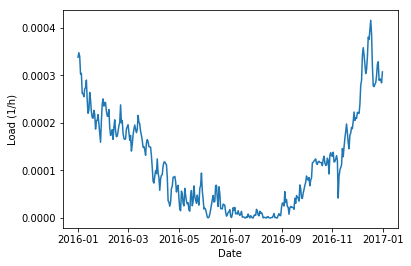

In [9]:
#Residential space heating demand is derived from proprietary residenrial load data from 2995 dwellings in the Lower Mainland
#of British Columbia, spanning November 2015 to October 2017. 890 of those dewllings are taggged to use electric heating.
P_R = pd.read_excel('../data/demand/heat/residential/Residential_electric_demand_profile_by_housetype.xlsx', sheet_name='2016_wout_Feb29_wout_DaylightST')

#lets create a datetime column
P_R['Datetime'] = pd.to_datetime(P_R['Date'].astype(str) + ' ' + (P_R['HE'] -1).astype(str) + ':00')

#Weights are the number of electrically heated dwellings for this type dwelling in the dataset.
#We assume that the dataset is a representative sample of British Columbia and Vancouver.
wLR = 265 #low-rise Apartments
wSD = 233 #Single/Duplex Homes
wHR = 198 #High-rise Apartments
wRH = 174 #Row Houses
wMH = 20  #Mobile Homes

#Weight each housetypes demand by the number of houses to create the total residential demand
P_R['Total'] = (P_R['Residential - Low-Rise Apt Suites (Elec Heat)'] * wLR +
                P_R['Residential - High-Rise Apt Suites (Elec Heat)'] * wHR +
                P_R['Residential - Row Houses Units (Elec Heat)'] * wRH +
                P_R['Residential - Single/Duplex (Elec Heat)'] * wSD +
                P_R['Residential - Mobile (Elec Heat)'] * wMH
               )

#Normalize the resdidential demand profile
P_R['Normalized_Total'] = P_R['Total'] / P_R['Total'].sum()
                
#plot the demand profile
ax = sns.lineplot(x = P_R['Date'], y = P_R['Normalized_Total'], legend = 'full', ci = None)
ylabel = plt.ylabel('Load (1/h)')

### Commercial & Institutional Demand Profile

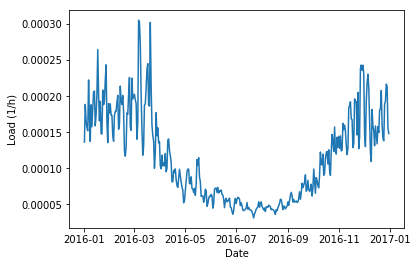

In [10]:
#Commmercial space heat demand profile is derived from 16 types of reference building models published by US DOE.
#Buildings are weighted to match the building stock in British Columbia
#source data available at: https://openei.org/doe-opendata/dataset/commercial-and-residential-hourly-load-profiles-for-all-tmy3-locations-in-the-united-states

#File names are rather long, let's define the prefix and suffix of file names to save space.
pre = 'RefBldg'
suf = 'New2004_v1.3_7.1_4C_USA_WA_SEATTLE.csv'

#Dictionary of buidling types and their resective weights. Weights are approximated by the number of 
#establishements surveyed in British Columbia from Table 2.1 in 
#"Natural Resources Canada, 2013. Survey of commercial and institutional energy use: establishments 2009"
#http://oee.nrcan.gc.ca/publications/statistics/scieu/2009/pdf/SCIEU2009Establishments.pdf
bldgDict = {'FullServiceRestaurant' : 8254, #Food Services and Drinking Places (722)
            'Hospital' : 81 + 1152, #81 Hostpitals (622) + 1152 Nursing and Residential Care Facilities (623)
            'LargeHotel': round(1691/2), # half of 1691 Accommodation Services (721)
            'LargeOffice' :  672 + 26, # 672 Public Administration (91) + 26 Universities (6113)
            'MediumOffice' :3072 + 2076, # 3072 Religious Organizations (813110) + 2076 Arts, Entertainment and Recreation (71)
            'MidriseApartment' : 0,
            'OutPatient' : 7771 + 1905, # 7771 Ambulatory Health Care Services (621) + 1905 Social Assistance (624) 
            'PrimarySchool' : round(1909/2), # half of 1909 Primary and Secondary Schools (6111) 
            'QuickServiceRestaurant' : 0,
            'SecondarySchool' : round(1909/2) + 1477, # half of 1909 Primary and Secondary Schools (6111)+ 1477 Colleges, CÉGEPs and Other Schools (6112, 6114, 6115, 6116, 6117)
            'SmallHotel' : round(1691/2), # half of 1691 Accommodation Services (721)
            'SmallOffice' : 1185 + 23978, #1185 Information and Cultural Industries (51) + 23978 Financial, Real Estate and Other Professional Services (52–56)
            'Stand-aloneRetail' : 14364,#Retail trade (44 - 45, excluding 445)
            'StripMall' :0,
            'SuperMarket' : 2486, #Food and Beverage Industries (445)
            'Warehouse' : 8141 + 11105} # 8141 Wholesale and Warehousing (41 & 49) + 11105 Transportation and Other Services (48 and 81) (Except 813110) 

#the name of the column contains the heat demand in each csv file
heatColumn = 'Heating:Gas [kW](Hourly)'

#Create a data frame with the dates and HE (hour ending) from our P_R dataframe to store our heat demand.
P_C = P_R.loc[:,'Date':'HE']
P_C = P_C.reset_index(drop=True)

#lets create a datetime column
P_C['Datetime'] = pd.to_datetime(P_C['Date'].astype(str) + ' ' + (P_C['HE'] -1).astype(str) + ':00')

#Read the csv files and add the heating demand colomn from each csv file to our dataframe
for bldg, weight in bldgDict.items():
    
    #read each entire csv
    dfTemp = pd.read_csv('../data/demand/heat/commercial/'+pre+bldg+suf)
    
    #copy the column with the heat demand into our dataframe
    P_C.loc[:,bldg] = dfTemp.loc[:, heatColumn] * weight

#Create the sum of all building demands
P_C.loc[:,'Total'] = P_C.loc[:, bldgDict.keys()].sum(axis=1)

#Normalize the total Commercial, Institutional and Publich Administration building demands
P_C['Normalized_Total'] = P_C['Total'] / P_C['Total'].sum()

#Plot the commercial & institutional demand profile
ax = sns.lineplot(x = P_C['Date'], y = P_C['Normalized_Total'], legend = 'full', ci = None)
ylabel = plt.ylabel('Load (1/h)')

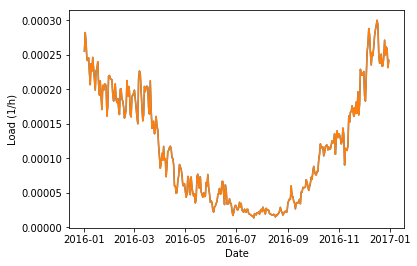

In [11]:
#Create the combined space heat demand profile from the residential
#and the commercial & institutional profile
P_H = P_R.loc[:,'Date':'HE']

#lets create a datetime column
P_H['Datetime'] = pd.to_datetime(P_H['Date'].astype(str) + ' ' + (P_H['HE'] -1).astype(str) + ':00')

#Create separate heat demand profiles for HIGH and LOW scenarios
P_H['LOW_Demand'] = (P_R['Normalized_Total'] * E_R_LOW) + (P_C['Normalized_Total'] * E_C_LOW)
P_H['HIGH_Demand'] = (P_R['Normalized_Total'] * E_R_HIGH) + (P_C['Normalized_Total'] * E_C_HIGH)

#Create normalized heat demand profiles (These normalized profiles should be equivalent to each other!)
P_H['Normalized_LOW_Demand'] = P_H['LOW_Demand'] / P_H['LOW_Demand'].sum()
P_H['Normalized_HIGH_Demand'] = P_H['HIGH_Demand'] / P_H['HIGH_Demand'].sum()

#Plot the combined residential and commercial & institutional demand profile
ax = sns.lineplot(x = P_H['Date'], y = P_H['Normalized_LOW_Demand'], legend = 'full', ci = None)
ax2 = sns.lineplot(x = P_H['Date'], y = P_H['Normalized_HIGH_Demand'], legend = 'full', ci = None)
ylabel = plt.ylabel('Load (1/h)')

## Transportation Demand Profile

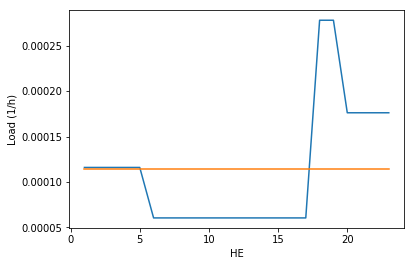

In [12]:
#Create a data frame with the dates and HE (hour ending) from our to store our transportation demand.
P_T = P_R.loc[:,'Date':'HE']
P_T = P_T.reset_index(drop=True)

#lets create a datetime column
P_T['Datetime'] = pd.to_datetime(P_T['Date'].astype(str) + ' ' + (P_T['HE'] -1).astype(str) + ':00')

#UNIFORM-Scenario
P_T['UNIFORM'] = 1/8760

#PEAK-Scenario
#read the 24h demand profile
dfTemp=pd.read_csv('../data/demand/transportation/2019_06_21_Vehicle demand profile BC_24h.csv')

#repeat the 24h profile for all 365 days and normalize
dfTemp2 = pd.concat([dfTemp]*365, ignore_index=True)
dfTemp2['Normalized_Demand'] = dfTemp2 ['Demand'] / dfTemp2 ['Demand'].sum() 

#copy the normalized peak demand profile into our profile dataframe
P_T['PEAK']= dfTemp2['Normalized_Demand']

#Plot the transportation demand profiles
ax = sns.lineplot(x = P_T['HE'][0:23], y = P_T['PEAK'][0:23], legend = 'full', ci = None)
ax2 = sns.lineplot(x = P_T['HE'][0:23], y = P_T['UNIFORM'][0:23], legend = 'full', ci = None)
ylabel = plt.ylabel('Load (1/h)')


## Remaining Electricity Demand Profile
based on BC's historic hourly puplished by the BC Balancing Authority 

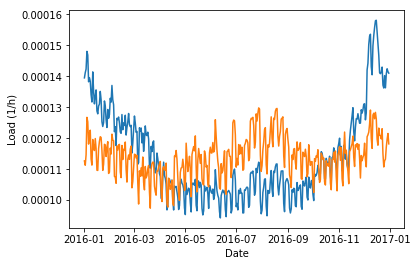

In [13]:
#Present day electricity demand in British Columbia [MW]
P_E = pd.read_excel('../data/demand/electricity/BalancingAuthorityLoad2016_wout_29Feb_summertime.xls', sheet_name='wout_Feb29_wout_DaylightST', skiprows=1)
P_E = P_E.rename(index=str, columns={'Balancing Authority Load': 'BA_Demand'})
P_E.columns.values[0] = 'Date'

#lets create a datetime column
P_E['Datetime'] = pd.to_datetime(P_E['Date'].astype(str) + ' ' + (P_E['HE'] -1).astype(str) + ':00')

#Normalize the load profile by deviding the hourly load by the annual demand
P_E.loc[:,'Normalized_Gross_Demand'] = P_E.loc[:,'BA_Demand'] / P_E['BA_Demand'].sum()

#The BA Demand is the demand of all of BC, but lack of documentation renders it unclear which
#components (e.g. Fortis BC, imports/exports, Catalyst paper, etc.) are included. Therefore, we
#only use the profile and multiply that profile with our gross Vancouver electricity demand.
P_E.loc[:,'Gross_Demand'] = P_E.loc[:,'Normalized_Gross_Demand'] * get('E_G')

#let's reset the index because arithmetic with various dataframes was giving us problems
P_E = P_E.reset_index(drop=True)

#Subtract the historically electric space heat demand
P_E.loc[:,'Net_Demand'] = P_E.loc[:,'Gross_Demand'] - (P_R.loc[:,'Normalized_Total']*get('^E_R,e')+ P_C.loc[:,'Normalized_Total']*get('^E_C,e'))

#Compute the normalized net demand
P_E.loc[:,'Normalized_Net_Demand'] = P_E.loc[:,'Net_Demand'] / P_E.loc[:,'Net_Demand'].sum()  

#plot the gross and net remaining electricity demand profiles
ax = sns.lineplot(x = P_E['Date'], y = P_E['Normalized_Gross_Demand'], legend = 'full', ci = None)
ax2 = sns.lineplot(x = P_E['Date'], y = P_E['Normalized_Net_Demand'], legend = 'full', ci = None)
ylabel = plt.ylabel('Load (1/h)')

## Total Electricity Demand Profile
The total electrified demand profile including space heat and road transportation

In [14]:
#Create the Dataframe appropriate date and HE (hour ending) columns
P_D = pd.DataFrame()
P_D['Date'], P_D['HE'] = P_E['Date'], P_E['HE']

#lets create a datetime column
P_D['Datetime'] = pd.to_datetime(P_D['Date'].astype(str) + ' ' + (P_D['HE'] -1).astype(str) + ':00')

#The total electricity demand is the sum of space heat, transportation and remaining electricity demand.
#Space heat is subdivided into residential and commercial & institutional demand
#Transportation only has a single demand profile
#remaining electricity is the net electricity to avoid double counting of space heat
P_D['LOW-PEAK_Demand'] = (P_H['Normalized_LOW_Demand'] * E_H_LOW + 
                          P_T['PEAK'] * E_T +
                          P_E['Normalized_Net_Demand'] * E_E
                         )

P_D['HIGH-PEAK_Demand'] = (P_H['Normalized_HIGH_Demand'] * E_H_HIGH + 
                           P_T['PEAK'] * E_T +
                           P_E['Normalized_Net_Demand'] * E_E
                          )

P_D['LOW-UNIFORM_Demand'] = (P_H['Normalized_LOW_Demand'] * E_H_LOW + 
                             P_T['UNIFORM'] * E_T +
                             P_E['Normalized_Net_Demand'] * E_E
                            )

P_D['HIGH-UNIFORM_Demand'] = (P_H['Normalized_HIGH_Demand'] * E_H_HIGH + 
                              P_T['UNIFORM'] * E_T +
                              P_E['Normalized_Net_Demand'] * E_E
                             )
                          
#Normalize the profiles
P_D['Normalized_LOW-PEAK_Demand'] = P_D['LOW-PEAK_Demand'] / P_D['LOW-PEAK_Demand'].sum()
P_D['Normalized_HIGH-PEAK_Demand'] = P_D['HIGH-PEAK_Demand'] / P_D['HIGH-PEAK_Demand'].sum()
P_D['Normalized_LOW-UNIFORM_Demand'] = P_D['LOW-UNIFORM_Demand'] / P_D['LOW-UNIFORM_Demand'].sum()
P_D['Normalized_HIGH-UNIFORM_Demand'] = P_D['HIGH-UNIFORM_Demand'] / P_D['HIGH-UNIFORM_Demand'].sum()

# 3. Demand Profile Plots

## Normalized demand profiles

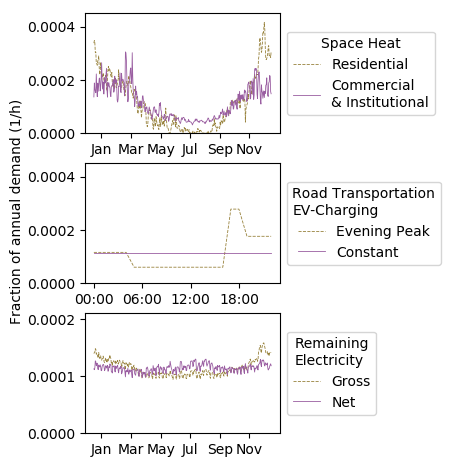

In [15]:
#create subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(3,6), dpi=100, sharex=False, sharey=False, squeeze=True)

##################################### 
#FIRST ROW: Space heat demand
##################################### 
#Residential space heat demand
#we'll plot the daily mean rather than hourly demand
#compute mean of every n rows: https://stackoverflow.com/questions/36810595/calculate-average-of-every-x-rows-in-a-table-and-create-new-table
axs[0].plot(P_R['Datetime'][::24], P_R['Normalized_Total'].groupby(P_R.index//24).mean(),
            linewidth=0.60, color='#98823c', linestyle='--', label='Residential')
axs[0].plot(P_C['Datetime'][::24], P_C['Normalized_Total'].groupby(P_C.index//24).mean(), 
            linewidth=0.60, color='#9a5ea1', linestyle='-', label='Commercial\n& Institutional')
axs[0].legend(title ='Space Heat', loc='center left', bbox_to_anchor=(1,0.5), frameon=True)

#set y-limits
axs[0].set_ylim(0,0.00045)

#correct xtick label placement
#slicing is used to place labels in the middle of the month, and place every second only
locs = [matplotlib.dates.date2num(i) for i in P_R['Datetime'][15*24::1460]]
#format labels to display month as three-letter abbreviation
labels = [ i.strftime("%b") for i in P_R['Datetime'][15*24::1460] ]

# Now set the ticks and labels
axs[0].set_xticks(locs)
axs[0].set_xticklabels(labels)


##################################### 
#Second ROW: Transportation demand
##################################### 
#Transportation demand profiles
axs[1].plot(P_T['HE'][0:23],P_T['PEAK'][0:23],
            linewidth=0.60, color='#98823c', linestyle='--', label='Evening Peak')
axs[1].plot(P_T['HE'][0:23], P_T['UNIFORM'][0:23], 
            linewidth=0.60, color='#9a5ea1', linestyle='-', label='Constant')
axs[1].legend(title ='Road Transportation\nEV-Charging', loc='center left', bbox_to_anchor=(1,0.5), frameon=True)

#set y-limits
axs[1].set_ylim(0,0.00045)

#correct xtick label placement
locs = P_T['HE'][0:23:6]
#format labels to display month as three-letter abbreviation
labels = [ i.strftime("%H:%M") for i in P_T['Datetime'][0:23:6] ]

# Now set the ticks and labels
axs[1].set_xticks(locs)
axs[1].set_xticklabels(labels)

##################################### 
#THIRD ROW: Gross and net remaining electricity demand
##################################### 
#plot the gross and net remaining electricity demand profiles
axs[2].plot(P_E['Datetime'][::24], P_E['Normalized_Gross_Demand'].groupby(P_R.index//24).mean(),
            linewidth=0.60, color='#98823c', linestyle='--', label='Gross')
axs[2].plot(P_E['Datetime'][::24], P_E['Normalized_Net_Demand'].groupby(P_C.index//24).mean(), 
            linewidth=0.60, color='#9a5ea1', linestyle='-', label='Net')
axs[2].legend(title ='Remaining\nElectricity', loc='center left', bbox_to_anchor=(1,0.5), frameon=True)

#set y-limits
axs[2].set_ylim(0,0.00021)

#correct xtick label placement
#slicing is used to place labels in the middle of the month, and place every second only
locs = [matplotlib.dates.date2num(i) for i in P_E['Datetime'][15*24::1460]]
#format labels to display month as three-letter abbreviation
labels = [ i.strftime("%b") for i in P_E['Datetime'][15*24::1460] ]

# Now set the ticks and labels
axs[2].set_xticks(locs)
axs[2].set_xticklabels(labels)

##################################### 
#Figure Post Processing
##################################### 
#adjust plot placements within the figure
left = 0.25
right = 0.9
plt.subplots_adjust(left=left, right=right, bottom=0.18, wspace=0.05, hspace=0.25)

#place y-label
fig.text(x=0.00, y=0.55, s='Fraction of annual demand (1/h)', rotation=90, va='center', ha='left')

#Place row labels Space Heat, Road Transportation, Electricity
#lbls = ['Space\nHeat', 'Road\nTransportation', 'Electricity'][::-1]
#for i, ax in enumerate(axs):
#    fig.text(x=0.93, y=0.75*(i/3)+0.25, s=lbls[i], rotation=0, va='bottom', ha='left', wrap=True)

fig.savefig(path.join(fig_prefix,'normalized_demand_profiles.jpg'), dpi=100, bbox_inches="tight")

## Summary demand profiles

In [16]:
#this function fixes duplpicate legend entries when we create legends for figures with subplots
#see stackoverflow for explanation: https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend    
def fixDupesInLegend(figureHandle, legendOrder):
    #we need to cycle through all the axes and get all the handles so that we consider all Legend elements contained in any subplot
    #get all the axes contained in the figure
    axes = figureHandle.get_axes()
    #create an empty list of labels and handles
    label_list=[]
    handle_list=[]
    #cycle through the axes to get their labels and handles
    for i, ax in enumerate(axes):
        handles, labels = ax.get_legend_handles_labels()
        label_list.append(labels)
        handle_list.append(handles)
    #we need to flatten the label_list and the handles_list, because it is currently a list of lists (which we don't want)
    #see explanation on flattening: https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
    l = [item for sublist in label_list for item in sublist]
    h = [item for sublist in handle_list for item in sublist]
    by_label = dict(zip(l, h))
    #sort the dictionary, based on the legendOrder
    #see https://stackoverflow.com/questions/21773866/how-to-sort-a-dictionary-based-on-a-list-in-python
    by_label_sorted = OrderedDict(sorted(by_label.items(), key=lambda pair: legendOrder.index(pair[0])))
    #reverse the order of the legend entries when returning, so that solar is on the top
    return reversed(by_label_sorted.values()), reversed(by_label_sorted.keys())

#this function sets the title above a figure column
def setTitle(ax, row, title):
    #only set the title in the top row
    if row==0:
        ax.set(title=title)

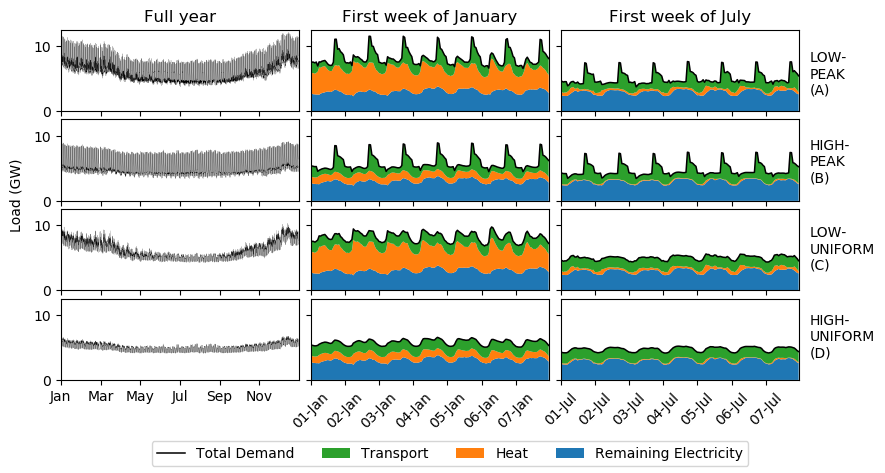

In [17]:
#plot the profiles
#some configuration
scenarios = ['LOW-PEAK', 'HIGH-PEAK', 'LOW-UNIFORM', 'HIGH-UNIFORM']
figsize=(10,5)
ylims = (0,12.5)
y_text = 'Load (GW)'
tcklbls = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#create subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=figsize, dpi=100, sharex='col', sharey=True, squeeze=True)

##################################### 
#FIRST COLUMN: full years
##################################### 
for i, scn in enumerate(scenarios):
    #sns.lineplot(x = P_D['Datetime'], y = P_D[scn+'_Demand']*1000, legend = 'full', ci = None, ax=axs[i][0], linewidth=0.10, color='black')
    axs[i][0].plot(P_D['Datetime'], P_D[scn+'_Demand']*1000, linewidth=0.10, color='black', label='Total Demand')
    axs[i][0].set_ylabel('')
    axs[i][0].set_xlabel('')
    axs[i][0].set_ylim(ylims)
    axs[i][0].set_xlim(P_D.at[0,'Datetime'],P_D.at[8759,'Datetime'])
      
    #correct xtick label placement
    locs = [matplotlib.dates.date2num(i) for i in P_D['Datetime'][::1460]]
    #format labels to display month as three-letter abbreviation
    labels = [ i.strftime("%b") for i in P_D['Datetime'][::1460] ]

    # Now set the ticks and labels
    axs[i][0].set_xticks(locs)
    axs[i][0].set_xticklabels(labels)
    
    #set the title above the column
    setTitle(ax=axs[i][0], row=i, title='Full year')


#####################################    
#SECOND COLUMN: First week in January
##################################### 
#this solution to iterating over the heat and transportation scenarios is ugly but it works
H_scenarios = ['LOW', 'HIGH','LOW','HIGH']
T_scenarios = ['PEAK', 'PEAK', 'UNIFORM', 'UNIFORM']


for i, scn in enumerate(scenarios):
    #plot the heat, transport and remaining electricty demand
    axs[i][1].stackplot(P_D['Datetime'][0:168].values, 
                 P_E['Normalized_Net_Demand'][0:168].values * E_E*1000,
                 P_H[H_scenarios[i]+'_Demand'][0:168].values * 1000, 
                 P_T[T_scenarios[i]][0:168].values * E_T*1000,
                 labels=['Remaining Electricity', 'Heat', 'Transport'],
                 linewidth=0
                )
    #plot total demand
    axs[i][1].plot(P_D['Datetime'][0:168], P_D[scn+'_Demand'][0:168]*1000, linewidth=1.10, color='black', label='Total Demand')
    axs[i][1].set_ylabel('')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylim(ylims)
    axs[i][1].set_xlim(P_D.at[0,'Datetime'],P_D.at[167,'Datetime'])
    
    #correct xtick label placement
    locs = [matplotlib.dates.date2num(i) for i in P_D['Datetime'][0:168:24]]
    #format labels to display month as three-letter abbreviation
    labels = [ i.strftime("%d-%b") for i in P_D['Datetime'][0:168:24] ]

    # Now set the ticks and labels
    axs[i][1].set_xticks(locs)
    axs[i][1].set_xticklabels(labels, rotation=45)
    
    #set the title above the column
    setTitle(ax=axs[i][1], row=i, title='First week of January')
    
#####################################    
#THIRD COLUMN: First week in July
##################################### 
for i, scn in enumerate(scenarios):
    #plot the heat, transport and remaining electricty demand
    axs[i][2].stackplot(P_D['Datetime'][4344:4512].values, 
                 P_E['Normalized_Net_Demand'][4344:4512].values * E_E*1000,
                 P_H[H_scenarios[i]+'_Demand'][4344:4512].values *1000, 
                 P_T[T_scenarios[i]][4344:4512].values * E_T*1000,
                 labels=['Remaining Electricity', 'Heat', 'Transport'],
                 linewidth=0
                )
    #plot total demand
    axs[i][2].plot(P_D['Datetime'][4344:4512], P_D[scn+'_Demand'][4344:4512]*1000, linewidth=1.10, color='black', label='Total Demand')
    axs[i][2].set_ylabel('')
    axs[i][2].set_xlabel('')
    axs[i][2].set_ylim(ylims)
    axs[i][2].set_xlim(P_D.at[4344,'Datetime'],P_D.at[4511,'Datetime'])
    
    #correct xtick label placement
    locs = [matplotlib.dates.date2num(i) for i in P_D['Datetime'][4344:4512:24]]
    #format labels to display month as three-letter abbreviation
    labels = [ i.strftime("%d-%b") for i in P_D['Datetime'][4344:4512:24] ]

    # Now set the ticks and labels
    axs[i][2].set_xticks(locs)
    axs[i][2].set_xticklabels(labels, rotation=45)
    
    #set the title above the column
    setTitle(ax=axs[i][2], row=i, title='First week of July')
    
#####################################    
#Figure post-processing
##################################### 
    
#place y-label
fig.text(x=0.03, y=0.55, s=y_text, rotation=90, va='center', ha='left')

#place scenario labels to the right of the plots
scns = ['LOW-\nPEAK\n(A)', 'HIGH-\nPEAK\n(B)', 'LOW-\nUNIFORM\n(C)', 'HIGH-\nUNIFORM\n(D)']
for i, scn in enumerate(scns[::-1]):
    fig.text(x=0.83, y=0.7*(i/4)+0.22, s=scn, rotation=0, va='bottom', ha='left', wrap=True)

#add a legend
legendOrder=['Remaining Electricity', 'Heat', 'Transport','Total Demand']
lgd = fig.legend(*fixDupesInLegend(fig,legendOrder=legendOrder), loc='lower center', bbox_to_anchor=(0.45,0.0), frameon=True, ncol=4)

#calculate the appropriate width for the figure
#in units of 100 pixels, starting with wodth of legend on right + width of axis title on left + width of each of the 3 columns
width = 1.65 + 0.7 + 2.5 * 3 
#calculate how far left and right to put the plot borders within the image canvas (19.85*0.04 happens to be a nice factor)
left = (19.85/width) * 0.04
right = 1-((19.85/width) * (1-0.91))
plt.subplots_adjust(left=left, right=right, bottom=0.18, wspace=0.05, hspace=0.1)


fig.savefig(path.join(fig_prefix,'demand-scenarios.jpg'), dpi=100, bbox_inches="tight")

# 4. Create summary table with demand scenario overview

In [18]:
#Table Headings
headers = ['Scenario',
           'Description',
           'Demand Profile',
           'Space Heat Demand (TWh)',
           'Road Transportation Demand (TWh)',
           'Remaining Electricity Demand (TWh)',
           'Total Annual Electricity Demand (TWh)']

#Table content
scenarios = ['LOW-PEAK', 'HIGH-PEAK', 'LOW-UNIFORM', 'HIGH-UNIFORM']

description_LOW = 'Heat: elec. resistance'
description_HIGH = 'Heat: heat pumps'
description_PEAK = 'EV-charging: evening peak'
description_UNIFORM = 'EV-charging: constant'

descriptions = [description_LOW +'\n'+description_PEAK,
                description_HIGH +'\n'+description_PEAK,
                description_LOW +'\n'+description_UNIFORM,
                description_HIGH +'\n'+description_UNIFORM
               ]
DemandProfile = ['(A)','(B)','(C)','(D)']
E_H_table = [round(i,1) for i in [E_H_LOW, E_H_HIGH, E_H_LOW, E_H_HIGH]]
E_T_table = [round(i,1) for i in [E_T, E_T, E_T, E_T]]
E_E_table = [round(i,1) for i in [E_E, E_E, E_E, E_E]]
E_D_table = [round(i,1) for i in [E_D_LOW, E_D_HIGH, E_D_LOW, E_D_HIGH]]

#create the table and save it to csv
data = np.transpose(np.array([scenarios, descriptions, DemandProfile, E_H_table, E_T_table, E_E_table, E_D_table]))
scenario_table = pd.DataFrame(data=data, columns=headers)
scenario_table.to_csv(path.join(tab_prefix,'scenario_table.csv'), index=False)


# 5. Create scenario-specific OSeMOSYS model input parameter files

In [19]:
#function to write a file in the OSeMOSYS parameter format
def demandAndProfile(annualDemand, demandProfile, file):
    with open(file, 'w') as f:
        #Annual demand
        f.write('# Demand\n')
        f.write('# SpecifiedAnnualDemand{r in REGION, f in FUEL, y in YEAR}  Units: GWh\n')
        f.write('# The annual requirement for each output fuel.\n')
        f.write('param SpecifiedAnnualDemand default 0 :=\n')
        f.write('[Vancouver,*,*]: 2015 :=\n')
        f.write('dELEC ' + str(annualDemand*1000) + '\n')
        f.write(';\n\n')
        
        #demand profile
        f.write('#param SpecifiedDemandProfile{r in REGION, f in FUEL, l in TIMESLICE, y in YEAR} Units: fraction of SpecifiedAnnualDemand per hour\n')
        f.write('# Normalized load profile, as in the hourly load as a fraction of the total annual demand\n')
        f.write('param SpecifiedDemandProfile default 0 :=\n')
        f.write('[Vancouver,*,*,2015]: ')
        [f.write(str(hour)+'\t') for hour in range(1,len(demandProfile)+1)]
        f.write('\n:=\n')
        f.write('dELEC ')
        [f.write(str(item)+'\t') for idx, item in demandProfile.iteritems()]
        f.write('\n;')
        

In [20]:
#Name of scenarios
scenarios = ['LOW-PEAK', 'HIGH-PEAK', 'LOW-UNIFORM', 'HIGH-UNIFORM']

#save to file called:
filesuffix = '_demand_and_profile.txt'

#write to file using our previously defined function
for scn in scenarios:
    #this is hacky, but gets around the fact that we have low and high annual demand stored in separate variables.
    if 'LOW' in scn:
        demandAndProfile(E_D_LOW, P_D['Normalized_'+scn+'_Demand'], path.join(para_prefix,scn + filesuffix))
    if 'HIGH' in scn:
        demandAndProfile(E_D_HIGH, P_D['Normalized_'+scn+'_Demand'], path.join(para_prefix,scn + filesuffix))

# 6. Create general-use csv file with total hourly electricity demand in Metro Vancouver (for easy re-use)

unit of columns "\*\_Demand": TW

unit of columns "Normalized_\*\_Demand": 1/h (fraction of total annual demand)

\* = {LOW-PEAK, HIGH-PEAK, LOW-UNIFORM, HIGH-UNIFORM}


In [21]:
#Name of scenarios
scenarios = ['LOW-PEAK', 'HIGH-PEAK', 'LOW-UNIFORM', 'HIGH-UNIFORM']

#save to file called:
total_hourly_demand_file = 'total_hourly_demands.csv'

#convert the demands from TW to GW
for s in scenarios:
    P_D[s+'_Demand'] = P_D[s+'_Demand'] * 1000

#save the total hourly demands and the hourly demand profiles to a csv
P_D.to_csv(path.join(demand_prefix,total_hourly_demand_file), index_label='Hour_number')

In [ ]:
#EOF